## Ανάλυση IMDB δεδομένων
### Random Forest Ταξινομητής

Ορίζουμε τις **υπερπαραμέτρους** που θα χρησιμοποιηθούν για την ανάπλαση των δωσμένων δεδομένων.

In [1]:
m = 500   # Πλήθος λέξεων του λεξιλογίου
n = 50     # Πιο συχνές λέξεις για παράληψη
k = 0      # Λιγότερο συχνές λέξεις για παράληψη

Αντλούμε τα δεδομένα από τη βάση δεδομένων IMDB, αγνοώντας τις πιο συχνά χρησιμοποιούμενες λέξεις n και τις λιγότερες χρησιμοποιούμενες λέξεις k. (υπερπαράμετροι)

In [2]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Δημιουργία δυαδικών διανυσμάτων

Μετατρέπουμε τα αντλημένα δεδομένα σε δυαδικά διανύσματα. Οι δυνατές τιμές είναι 0 και 1. Τιμή 1 συνεπάγεται ότι η αντίστοιχη λέξη περιέχεται στο κείμενο, ενώ τιμή 0 συνεπάγεται ότι δεν περιέχεται.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

Vocabulary size: 441


Χ είναι ένας πίνακας διανυσμάτων (αξιολογήσεων), με κάθε διάνυσμα να αναπαριστά λέξεις. Y είναι ένα διάνυσμα με ετικέτες (0 ή 1) όπου 0 είναι μια αρνητική αξιολόγηση και 1 μια θετική.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Υλοποίηση του Random Forest Ταξινομητή

Κλάση που υλοποιεί τον Random Forest Ταξινομητή. Η κλαση αποτελείται από δύο βασικές μεθόδους, την fit και την predict. Η μέθοδος fit εκπαιδεύει τον αλγόριθμο χρησιμόποιώντας τον πίνακα των δυαδικών διανυσμάτων X και τον πίνακα με τις ετικέτες y. Η μέθοδος predict δέχεται ένα πίνακα διανυσμάτων και επιστρέφει ένα προβλεπόμενο διάνυσμα με ετικέτες.

In [5]:
from statistics import mode
import numpy as np
from id3 import ID3

class RandomForest:
    def __init__(self, m=200, num_of_trees=3, max_depth=10):
        self.m = m
        self.num_of_trees = num_of_trees
        self.max_depth = max_depth
        self.random_trees = []

    def fit(self, X, y):
        self.random_trees.clear()
        print("Starting fitting process")

        for i in range(self.num_of_trees):
            print(f"Fitting tree {i + 1}/{self.num_of_trees}")
            random_x, random_y = self.select_random_samples(X, y)

            if len(random_x) > 0:
                print(f"Random samples: {random_x.shape}")
                random_features = self.select_random_features(random_x)
                id3 = ID3(features=random_features)
                tree = id3.fit(random_x, random_y)
                
                
                if tree is not None:  # Check if a valid tree is returned
                    print(f"Tree {i + 1} fitted successfully")
                    self.random_trees.append(id3)
                else:
                    print(f"Skipping tree {i + 1} due to empty data or other issues.")
            else:
                print(f"Skipping tree {i + 1} due to empty data.")

        print("Fitting process completed")

    def select_random_samples(self, X, y):
        x_sample = list()
        y_sample = list()
        indices = np.arange(len(y))

        for i in range(len(y)):
            random_choice = np.random.choice(indices)
            x_sample.append(X[random_choice])
            y_sample.append(y[random_choice])

        x_sample = np.array(x_sample)
        y_sample = np.array(y_sample)   

        return x_sample, y_sample

    def select_random_features(self, random_x):
        indices = np.arange(len(random_x[0]))
        random_feature_indices = np.random.choice(indices, self.m, replace=False)

        return random_feature_indices
    
    def predict(self, X):
        predictions = []
        total = list()
        
        for tree in self.random_trees:
            categories = tree.predict(X)
            total.append(np.array(categories))

        for i in range(0, X.shape[0]):################ 
            num1 = 0
            num0 = 0
            for category in total:
                if(category[i] == 1):
                    num1 +=1
                else:
                    num0 +=1
            if num1 > num0:
                predictions.append(1)
            else:
                predictions.append(0)

        return np.array(predictions)

In [4]:
from visualizations import *

In [25]:
rf=RandomForest(m=200, num_of_trees = 3, max_depth=10)

rf.fit(x_train_binary,y_train)
print(classification_report(y_test,rf.predict(x_test_binary)))

Starting fitting process
Fitting tree 1/3
Random samples: (25000, 2893)
Tree 1 fitted successfully
Fitting tree 2/3
Random samples: (25000, 2893)
Tree 2 fitted successfully
Fitting tree 3/3
Random samples: (25000, 2893)
Tree 3 fitted successfully
Fitting process completed
              precision    recall  f1-score   support

           0       0.65      0.62      0.64     12500
           1       0.64      0.67      0.65     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000



## Αποτελέσματα του Random Forest Ταξινομητή

Ο Random Forest Classifier αξιολογείται στα στα υπάρχοντα datasets και παράγει για κάθε υποσύνολο δεδομένων αποκρίσεις εκπαίδευσης και αξιολόγισης.

In [9]:
data = classification_data(RandomForest(m=200, num_of_trees = 3, max_depth=10), x_train_binary, y_train, x_test_binary, y_test, 5)
data_table = classification_table(data, x_train_binary)
ipd.display(data_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.94,0.70,0.94,0.70,0.95,0.70,0.94,0.70
10000,0.95,0.72,0.95,0.71,0.95,0.72,0.95,0.72
15000,0.95,0.71,0.94,0.71,0.95,0.72,0.95,0.71
20000,0.95,0.72,0.95,0.71,0.95,0.73,0.95,0.72
25000,0.95,0.71,0.95,0.71,0.95,0.72,0.95,0.72


### Καμπύλη Μάθησης του Random Forest

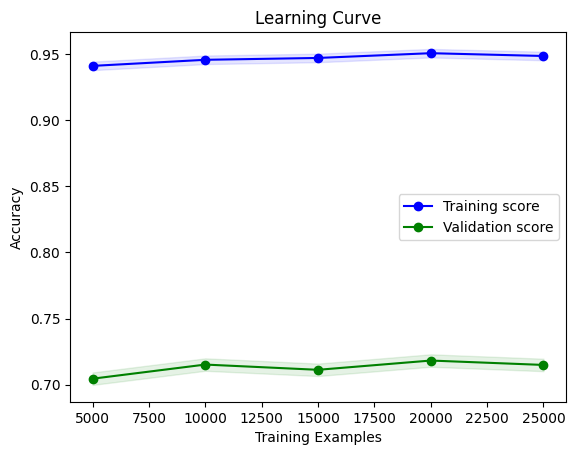

In [38]:
plot_learning_curve(data)

### Καμπύλες ακρίβειας, προσεγγιστικής ακρίβειας, ανάκλησης και F1

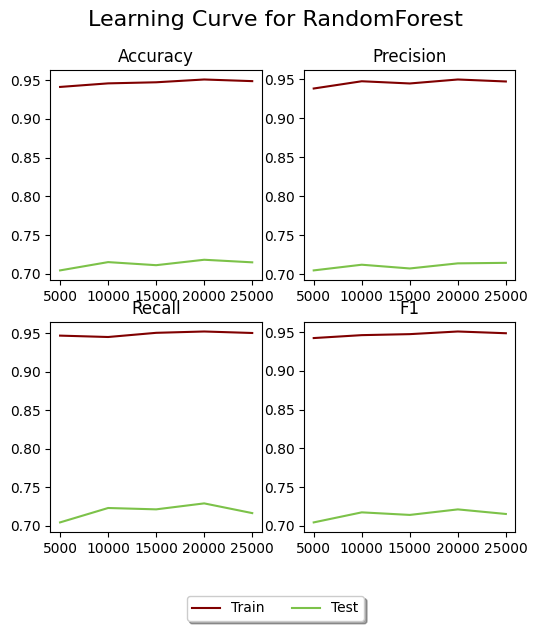

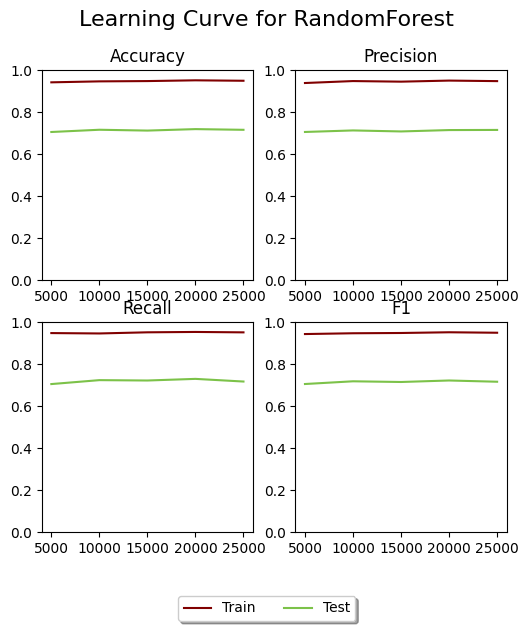

In [40]:
classification_plots(data)
r = classification_plots(data, True)

## Σύγκριση Random Forest και SKLearn's Random Forest

Ο Random Forest αξιολογείται ενάντια στον Random Forest Classifier της βιβλιοθήκης SKLearn. Τα αποτελέσματα είναι πανομοιότυπα μεταξύ τους. Παρακάτω παρουσιάζεται ο πίνακας διαφοράς των αποτελεσμάτων των 2 αλγορίθμων.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='entropy', max_features=200, n_estimators=3, max_depth=10)
rf_data = classification_data(rf, x_train_binary, y_train, x_test_binary, y_test, 5)
rf_data['estimator'] = "SKLearn's Random Forest"
rf_table = classification_table(rf_data, x_train_binary)
difference_table = abs(rf_table - data_table)
difference_table = difference_table.style.set_caption('Πίνακας Διαφοράς για τον {estimator} και τον {estimator_2}'.format(estimator=data['estimator'], estimator_2=rf_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.150000,0.020000,0.210000,0.030000,0.030000,0.150000,0.120000,0.050000
10000,0.160000,0.010000,0.200000,0.010000,0.070000,0.100000,0.140000,0.030000
15000,0.190000,0.020000,0.230000,0.020000,0.060000,0.130000,0.160000,0.050000
20000,0.190000,0.010000,0.240000,0.020000,0.070000,0.110000,0.160000,0.040000
25000,0.180000,0.030000,0.230000,0.020000,0.070000,0.120000,0.160000,0.040000


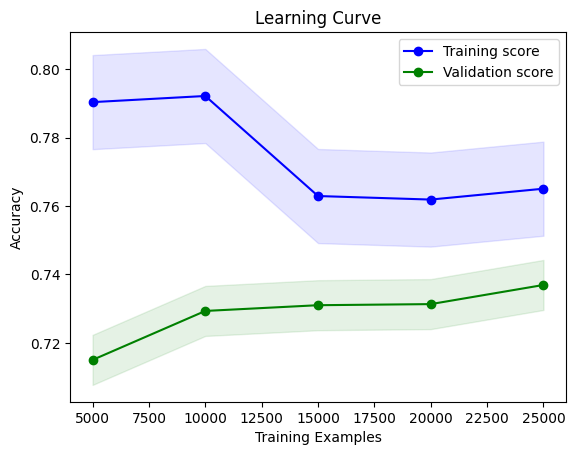

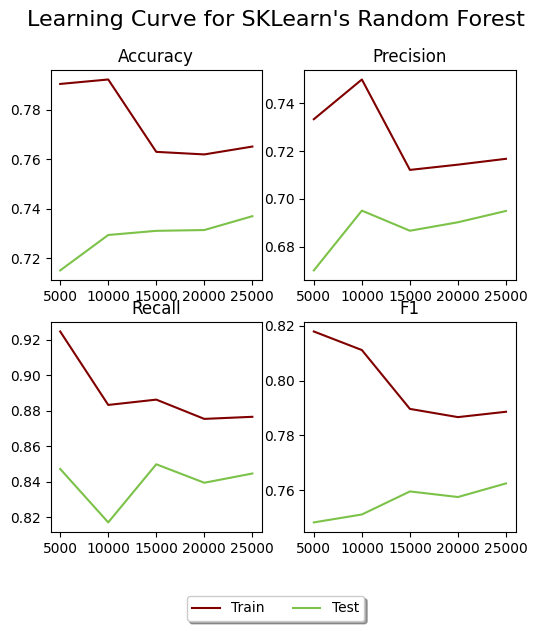

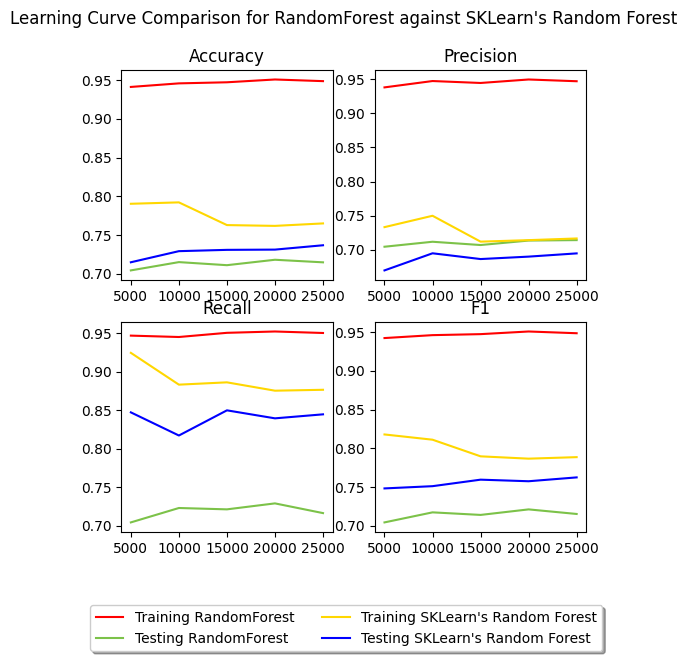

In [11]:
plot_learning_curve(rf_data)
classification_plots(rf_data)
r = classification_plots_compare(data, rf_data, False)

### Σύγκριση Random Forest και SKLearn's Ada Boost

Ο Random Forest αξιολογείται ενάντια στον Ada Boost της βιβλιοθήκης SKLearn. Τα αποτελέσματα είναι πανομοιότυπα μεταξύ τους. Παρακάτω παρουσιάζεται ο πίνακας διαφοράς των αποτελεσμάτων των 2 αλγορίθμων.

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     12500
           1       0.78      0.82      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.110000,0.100000,0.120000,0.090000,0.100000,0.120000,0.110000,0.100000
10000,0.130000,0.090000,0.140000,0.090000,0.110000,0.100000,0.120000,0.090000
15000,0.140000,0.100000,0.140000,0.090000,0.110000,0.100000,0.130000,0.100000
20000,0.130000,0.090000,0.140000,0.100000,0.120000,0.090000,0.130000,0.090000
25000,0.140000,0.100000,0.150000,0.100000,0.120000,0.110000,0.130000,0.100000


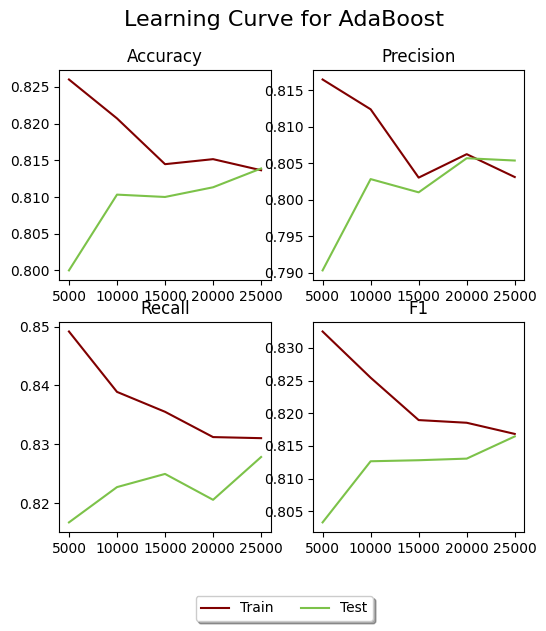

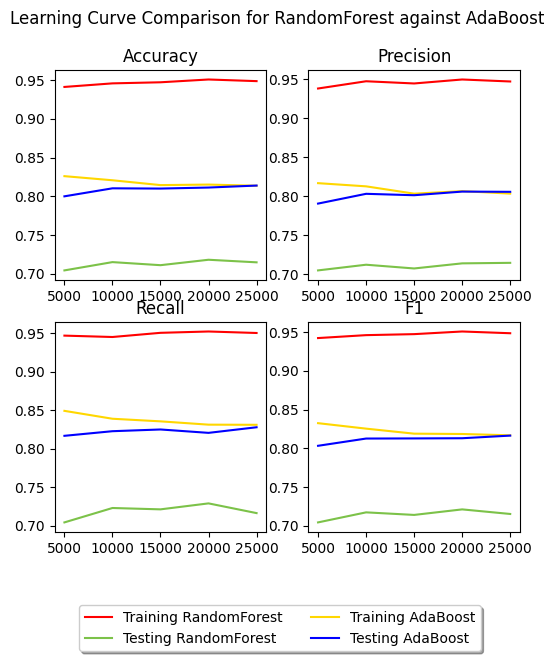

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier()
ada.fit(x_train_binary, y_train)
print(classification_report(y_test, ada.predict(x_test_binary), zero_division=1))

ada_data = classification_data(AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100), x_train_binary, y_train, x_test_binary, y_test, 5)
ada_data['estimator'] = 'AdaBoost'
ada_table = classification_table(ada_data, x_train_binary)
difference_table_ada = abs(ada_table - data_table)
difference_table_ada = difference_table_ada.style.set_caption('Πίνακας Διαφοράς για τον {estimator} και τον {estimator_2}'.format(estimator=data['estimator'], estimator_2=ada_data['estimator']))
ipd.display(difference_table_ada)

classification_plots(ada_data)
r = classification_plots_compare(data, ada_data)

### Επιλογή Υπερπαραμέτρων
Χρησιμοποιούμε τον παρακάτω κώδικα για να αποφασίσουμε ποιες υπερπαράμετροι είναι καλύτεροι. Σε 3 πίνακες Μ, Κ, Ν, έχουμε διάφορες τιμές με

M: αριθμός των λέξεων του λεξιλογίου

Ν: αριθμός των πιο συχνών λέξεων για να παραλειφθούν

Κ: αριθμός των πιο σπάνιων λέξεων για να παραλειφθούν

Χρησιμοποιούμε την ακρίβεια που δίνει ο ταξινομήτης πάνω στα δεδομένα ανάπτυξης για να αποφασίσουμε ποιος συνδυασμός m, n, k είναι ο καλύτερος.

In [29]:
from sklearn.model_selection import train_test_split

N = [50, 100, 200]
K = [0, 20, 50, 80]
M = [500, 2000, 2500]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            x_trainn, x_dev, y_trainn, y_dev = train_test_split(x_trainn, y_trainn, test_size=0.2)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in x_dev])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_val_binary = binary_vectorizer.transform(x_dev)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_val_binary = np.array(x_val_binary.toarray())
            
            rfc = RandomForest(m=200,num_of_trees=3)
            rfc. fit(x_trainn_binary, y_trainn)
            predicted_values = rfc.predict(x_val_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_dev, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))

Starting fitting process
Fitting tree 1/3
Random samples: (20000, 441)
Tree 1 fitted successfully
Fitting tree 2/3
Random samples: (20000, 441)
Tree 2 fitted successfully
Fitting tree 3/3
Random samples: (20000, 441)
Tree 3 fitted successfully
Fitting process completed
For M=500, N=50 and K=0:
Accuracy: 0.7164
Starting fitting process
Fitting tree 1/3
Random samples: (20000, 421)
Tree 1 fitted successfully
Fitting tree 2/3
Random samples: (20000, 421)
Tree 2 fitted successfully
Fitting tree 3/3
Random samples: (20000, 421)
Tree 3 fitted successfully
Fitting process completed
For M=500, N=50 and K=20:
Accuracy: 0.6914
Starting fitting process
Fitting tree 1/3
Random samples: (20000, 395)
Tree 1 fitted successfully
Fitting tree 2/3
Random samples: (20000, 395)
Tree 2 fitted successfully
Fitting tree 3/3
Random samples: (20000, 395)
Tree 3 fitted successfully
Fitting process completed
For M=500, N=50 and K=50:
Accuracy: 0.7062
Starting fitting process
Fitting tree 1/3
Random samples: (200